In [1]:
import os,math,random, gc,datetime
import platform
import logging
logging.getLogger().setLevel(logging.CRITICAL)

#package imports
import numpy as np
import pandas as pd
from tqdm import tqdm

#plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

#local imports
from utils.helpers import find_play_type

#Stats imports
import statsmodels as sm
from scipy import stats

#File paths below
#check kaggle or local
if platform.platform() == 'Linux-5.15.133+-x86_64-with-glibc2.31':
    FILE_PATH = '/kaggle/input/nfl-big-data-bowl-2024'
else:
    FILE_PATH = './nfl-big-data-bowl-2024'
GAMES_PATH = os.path.join(FILE_PATH,'games.csv')
PLAYS_PATH = os.path.join(FILE_PATH,'plays.csv')
PLAYERS_PATH = os.path.join(FILE_PATH,'players.csv')
TACKLES_PATH = os.path.join(FILE_PATH,'tackles.csv')

#Tracking weeks
WEEK1_PATH = os.path.join(FILE_PATH,'tracking_week_1.csv')
WEEK2_PATH = os.path.join(FILE_PATH,'tracking_week_2.csv')
WEEK3_PATH = os.path.join(FILE_PATH,'tracking_week_3.csv')
WEEK4_PATH = os.path.join(FILE_PATH,'tracking_week_4.csv')
WEEK5_PATH = os.path.join(FILE_PATH,'tracking_week_5.csv')
WEEK6_PATH = os.path.join(FILE_PATH,'tracking_week_6.csv')
WEEK7_PATH = os.path.join(FILE_PATH,'tracking_week_7.csv')
WEEK8_PATH = os.path.join(FILE_PATH,'tracking_week_8.csv')
WEEK9_PATH = os.path.join(FILE_PATH,'tracking_week_9.csv')



## Load Data

In [42]:
games_df = pd.read_csv(GAMES_PATH)
players_df = pd.read_csv(PLAYERS_PATH)
plays_df = pd.read_csv(PLAYS_PATH)
tackles_df = pd.read_csv(TACKLES_PATH)

#tracking week 1
week1_df = pd.read_csv(WEEK1_PATH)
week2_df = pd.read_csv(WEEK2_PATH)
week3_df = pd.read_csv(WEEK3_PATH)
week4_df = pd.read_csv(WEEK4_PATH)
week5_df = pd.read_csv(WEEK5_PATH)
week6_df = pd.read_csv(WEEK6_PATH)
week7_df = pd.read_csv(WEEK7_PATH)
week8_df = pd.read_csv(WEEK8_PATH)
week9_df = pd.read_csv(WEEK9_PATH)

#concat all weeks
all_weeks = pd.concat([week1_df,week2_df,week3_df,week4_df,week5_df,week6_df,week7_df,week8_df,week9_df])
display(all_weeks.sample(4))

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
1145131,2022091111,2464,47932.0,Hunter Renfrow,18,2022-09-11 18:22:49.099999,13.0,LV,right,76.87,25.02,3.14,0.26,0.31,161.66,169.94,first_contact
1374125,2022100913,3407,52627.0,Geno Stone,42,2022-10-09 22:55:50.700000,26.0,BAL,right,69.76,44.70,1.19,3.31,0.11,215.93,107.34,NaN
1070440,2022110700,588,47896.0,Justice Hill,19,2022-11-07 20:39:07.900000,43.0,BAL,right,61.69,17.90,4.44,1.26,0.45,75.26,84.20,NaN
829959,2022100907,3235,43503.0,Elandon Roberts,49,2022-10-09 15:37:54.500000,52.0,MIA,right,111.13,17.77,0.34,0.93,0.04,301.75,48.74,NaN


### Breakdown to individual events

In [49]:
#event types:
'''
[nan, 'pass_arrived', 'pass_outcome_caught', 'tackle', 'run',
       'first_contact', 'ball_snap', 'handoff', 'touchdown',
       'out_of_bounds', 'man_in_motion', 'fumble', 'play_action',
       'pass_forward', 'lateral', 'autoevent_passforward',
       'autoevent_passinterrupted', 'line_set', 'qb_slide', 'shift',
       'run_pass_option', 'qb_sack', 'pass_shovel', 'autoevent_ballsnap',
       'snap_direct', 'fumble_defense_recovered',
       'fumble_offense_recovered', 'penalty_flag', 'safety',
       'pass_outcome_touchdown', 'penalty_accepted']
       '''

pass_plays = find_play_type(plays_df,'pass')
pass_index = plays_df[plays_df['playDescription'].isin(pass_plays)].index
pass_plays_df = plays_df.iloc[pass_index]
run_plays_df = plays_df.loc[~plays_df.index.isin(pass_index)]

Number of matches for pass: 5646


,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,...,0.160485,0.839515,-0.010865,0.010865,1.733344,-0.263424,NaN,NaN,NaN,NaN
3,2022100212,2007,46461,Mike Boone,(13:12) M.Boone left tackle to DEN 44 for 7 ya...,3,2,10,DEN,LV,...,0.620552,0.379448,-0.002451,0.002451,1.641006,-0.043580,NaN,NaN,NaN,NaN
4,2022091900,1372,47857,Devin Singletary,(8:33) D.Singletary right guard to TEN 32 for ...,2,1,10,BUF,TEN,...,0.836290,0.163710,0.001053,-0.001053,3.686428,-0.167903,NaN,NaN,NaN,NaN
6,2022100207,2933,38538,Ryan Tannehill,(13:31) (Shotgun) R.Tannehill scrambles up the...,4,3,5,TEN,IND,...,0.230881,0.769119,0.027645,-0.027645,0.137272,-1.269624,NaN,NaN,NaN,NaN
7,2022102310,56,46377,Jeffery Wilson,(15:00) J.Wilson left tackle to SF 32 for 7 ya...,1,1,10,SF,KC,...,0.568721,0.431279,0.001382,-0.001382,1.298699,0.282340,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12477,2022102307,1224,42358,Melvin Gordon,(14:18) (Shotgun) M.Gordon left tackle to NYJ ...,2,2,8,DEN,NYJ,...,0.458804,0.541196,-0.036002,0.036002,1.939443,-0.817222,NaN,NaN,NaN,NaN
12481,2022100204,123,43293,Ezekiel Elliott,(13:31) E.Elliott right tackle to WAS 38 for 1...,1,1,10,DAL,WAS,...,0.638600,0.361400,-0.011542,0.011542,3.642571,-0.504018,NaN,NaN,NaN,NaN
12483,2022101605,3371,44860,Joe Mixon,(9:35) (Shotgun) J.Mixon left end to CIN 47 fo...,4,1,10,CIN,NO,...,0.667054,0.332946,-0.005164,0.005164,2.115356,0.203819,NaN,NaN,NaN,NaN
12484,2022100207,2777,52449,Jonathan Taylor,(2:02) (Shotgun) J.Taylor up the middle to TEN...,3,1,10,IND,TEN,...,0.410611,0.589389,-0.046648,0.046648,3.946232,-0.976039,NaN,NaN,NaN,NaN


In [4]:
#individual events
pass_occurs = all_weeks[all_weeks['event']=='pass_forward']
pass_arrives = all_weeks[all_weeks['event']=='pass_arrived']
tackle_occurs = all_weeks[all_weeks['event']=='tackle']

#label the tackler
tackle_occurs['tackler'] = False

for i,r in tackles_df.iterrows():
    play = tackle_occurs[(tackle_occurs['gameId']==r['gameId']) & (tackle_occurs['playId']==r['playId'])]
    tackle_occurs.loc[play.index,'tackler'] = pd.Series(np.where((play['nflId']==r['nflId']),True,False), index=play.index)

pass_arrives['tackler'] = False

for i,r in tackles_df.iterrows():
    play = pass_arrives[(pass_arrives['gameId']==r['gameId']) & (pass_arrives['playId']==r['playId'])]
    pass_arrives.loc[play.index,'tackler'] = pd.Series(np.where((play['nflId']==r['nflId']),True,False), index=play.index)

pass_occurs['tackler'] = False

for i,r in tackles_df.iterrows():
    play = pass_occurs[(pass_occurs['gameId']==r['gameId']) & (pass_occurs['playId']==r['playId'])]
    pass_occurs.loc[play.index,'tackler'] = pd.Series(np.where((play['nflId']==r['nflId']),True,False), index=play.index)
    


C:\Users\batuu\AppData\Local\Temp\ipykernel_37052\2672042446.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tackle_occurs['tackler'] = False
C:\Users\batuu\AppData\Local\Temp\ipykernel_37052\2672042446.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_arrives['tackler'] = False
C:\Users\batuu\AppData\Local\Temp\ipykernel_37052\2672042446.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

## Individual event distribution

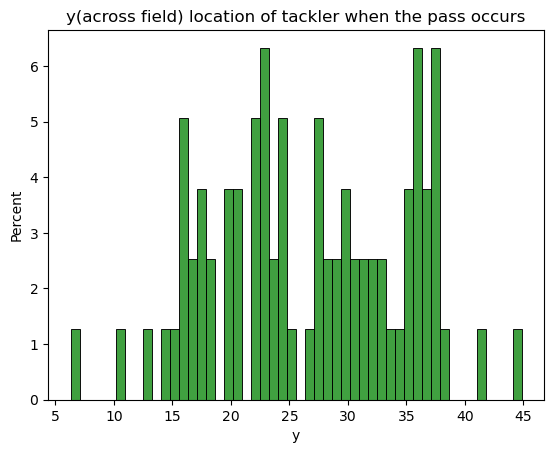

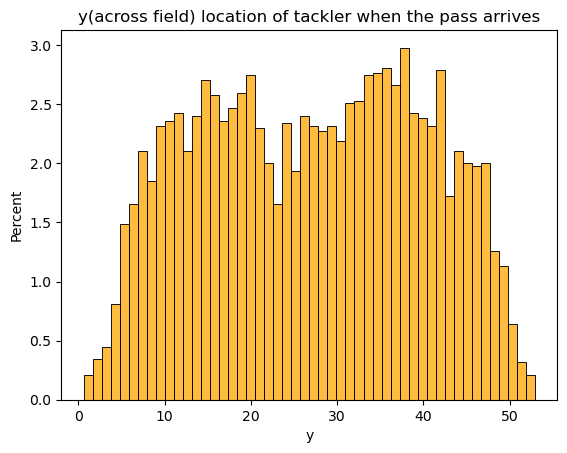

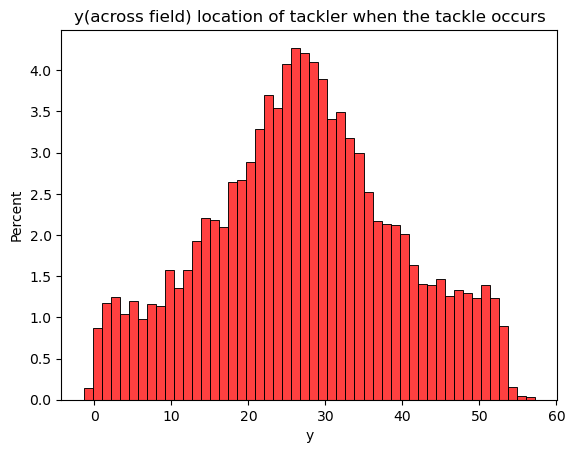

In [5]:
stat = 'y(across field) location'
col = 'y'

plt.title(f'{stat} of tackler when the pass occurs')
sns.histplot(x=col,data=pass_occurs[pass_occurs['tackler']==True],stat='percent',bins=50,color='green')
plt.show()
plt.cla()


plt.title(f'{stat} of tackler when the pass arrives')
sns.histplot(x=col,data=pass_arrives[pass_arrives['tackler']==True],stat='percent',bins=50,color='orange')
plt.show()
plt.cla()

plt.title(f'{stat} of tackler when the tackle occurs')
sns.histplot(x=col,data=tackle_occurs[tackle_occurs['tackler']==True],stat='percent',bins=50, color='red')
plt.show()
#tackle_occurs[tackle_occurs['tackler']==True]['y'].hist(bins=50)

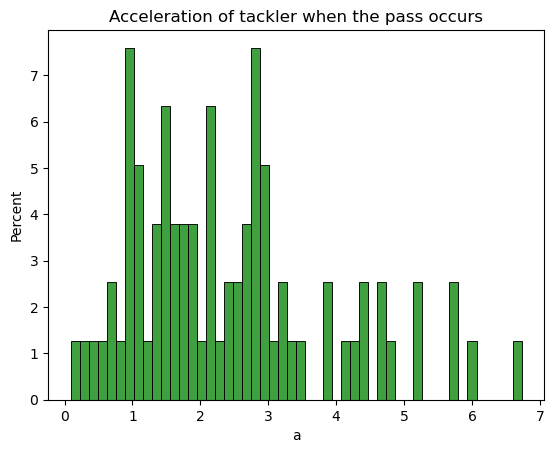

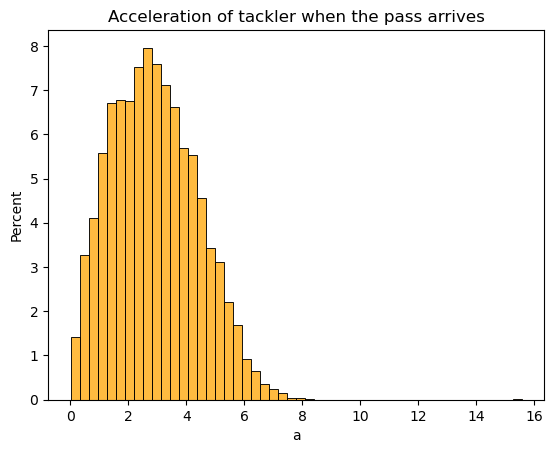

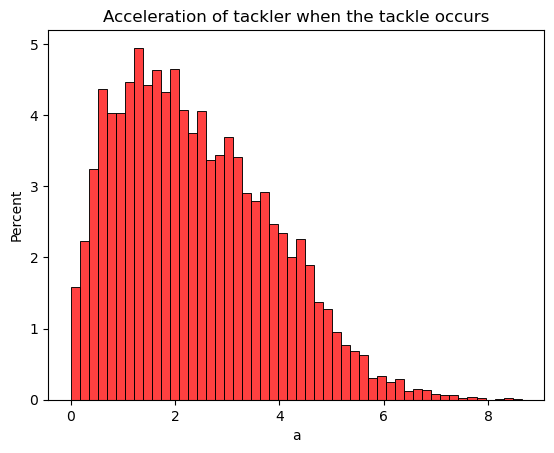

In [6]:
stat = 'Acceleration'
col = 'a'

plt.title(f'{stat} of tackler when the pass occurs')
sns.histplot(x=col,data=pass_occurs[pass_occurs['tackler']==True],stat='percent',bins=50,color='green')
plt.show()
plt.cla()


plt.title(f'{stat} of tackler when the pass arrives')
sns.histplot(x=col,data=pass_arrives[pass_arrives['tackler']==True],stat='percent',bins=50,color='orange')
plt.show()
plt.cla()

plt.title(f'{stat} of tackler when the tackle occurs')
sns.histplot(x=col,data=tackle_occurs[tackle_occurs['tackler']==True],stat='percent',bins=50, color='red')
plt.show()

In [7]:
pass_arrives2 = pass_arrives.copy()

pass_arrives2['result'] = 0
for i,r in pass_arrives2.iterrows():
    pass_arrives2.loc[i,'result'] = plays_df[(plays_df['playId']==r['playId']) & (plays_df['gameId']==r['gameId'])]['playResult'].values[0]

Correlation between tackler speed and play yards on catch: 0.1657
Significant p-value: 2.76e-30


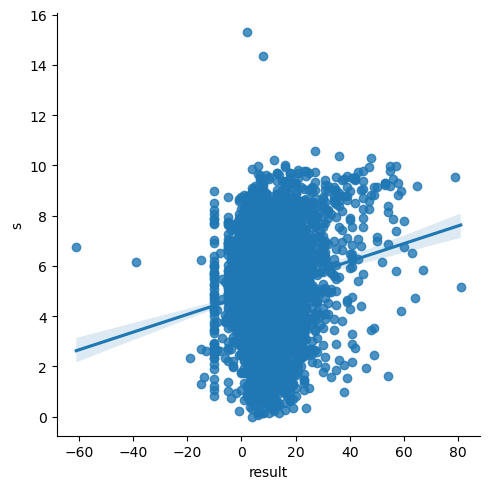

In [8]:
pa_tackle = pass_arrives2[pass_arrives2['tackler']==True]

r,p = stats.pearsonr(pa_tackle['result'],pa_tackle['s'])

print(f'Correlation between tackler speed and play yards on catch: {r:.4f}')


if p < 0.05:
    print('Significant',f'p-value: {p:.2e}')

sns.lmplot(x='result',y='s',data=pa_tackle)

## Trying to make a model of yards vs positon

This model will include the x, y, o (or dir), a, s. 

In [13]:
import torch
import torch.nn as nn

for i in 

